Dataset source: https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
df = pandas.read_csv('Telco-Customer-Churn.csv')

#### Data exploration

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# check column type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# stats from numeric columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Type conversion

# Looks like column TotalCharges is not numeric, because of missing values
df["TotalCharges"] = pandas.to_numeric(df["TotalCharges"], errors='coerce')

# Column SeniorCitizen: int64 --> Yes-No
df.loc[df['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
df.loc[df['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'


##### Information Gain

<BarContainer object of 19 artists>

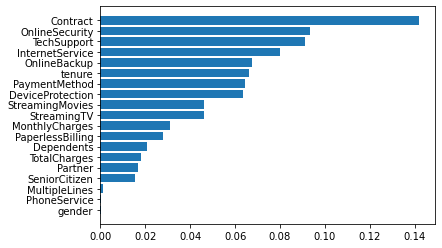

In [7]:
# Information Gain

def get_entropy(df, column_name):
    entropy = 0
    for val in df[column_name].unique():
        p = len(df[df[column_name]==val])/len(df)
        entropy -= p*numpy.log2(p)
    return entropy

def get_information_gain(df, split_name, target_name):
    information_gain = get_entropy(df, target_name) # entropy of entire dataset
    splitted_df_list = []
    # numeric feature --> split on mean
    if df[split_name].dtypes in ('int64', 'float64'):
        mean = df[split_name].mean()
        splitted_df_list.append(df[df[split_name] < mean])
        splitted_df_list.append(df[df[split_name] > mean])
    else:
        # categorical feature --> split on unique values
        for val in df[split_name].unique():
            splitted_df_list.append(df[df[split_name] == val])
    
    for splitted_df in splitted_df_list:
        information_gain -= (len(splitted_df)/len(df)) * get_entropy(splitted_df, target_name)
    return information_gain


# calculate Information Gain
target_column_name = 'Churn'
ignore_columns = ["customerID"]

columns = [col for col in df.columns if col not in ignore_columns+[target_column_name]]
IG_by_name = {}
for col in columns:
    IG_by_name[col] = get_information_gain(df, col, target_column_name)

"""
for k in sorted(IG_by_name, key = IG_by_name.get, reverse = True):
    print("{} --> {}".format(k, IG_by_name[k]))
"""

IG_df = pandas.DataFrame({"Attribute": IG_by_name.keys(), "IG": IG_by_name.values()})
IG_df = IG_df.sort_values(by = 'IG', ascending = True)

plt.barh(IG_df["Attribute"], IG_df["IG"])


#### Decision Tree Classification

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### Data preprocessing

In [9]:
# Check if OneHotEncoding is needed
unique_values_by_name = {}
for col in df.columns:
    if df[col].dtypes not in ('int64', 'float64'):
        unique_values_by_name[col] = len(df[col].unique())

for name in sorted(unique_values_by_name, key = unique_values_by_name.get, reverse = True):
    print("{} --> {} ({})".format(name, unique_values_by_name[name], df[name].unique()))

customerID --> 7043 (['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'])
PaymentMethod --> 4 (['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'])
MultipleLines --> 3 (['No phone service' 'No' 'Yes'])
InternetService --> 3 (['DSL' 'Fiber optic' 'No'])
OnlineSecurity --> 3 (['No' 'Yes' 'No internet service'])
OnlineBackup --> 3 (['Yes' 'No' 'No internet service'])
DeviceProtection --> 3 (['No' 'Yes' 'No internet service'])
TechSupport --> 3 (['No' 'Yes' 'No internet service'])
StreamingTV --> 3 (['No' 'Yes' 'No internet service'])
StreamingMovies --> 3 (['No' 'Yes' 'No internet service'])
Contract --> 3 (['Month-to-month' 'One year' 'Two year'])
gender --> 2 (['Female' 'Male'])
SeniorCitizen --> 2 (['No' 'Yes'])
Partner --> 2 (['Yes' 'No'])
Dependents --> 2 (['No' 'Yes'])
PhoneService --> 2 (['No' 'Yes'])
PaperlessBilling --> 2 (['Yes' 'No'])
Churn --> 2 (['No' 'Yes'])


In [10]:
"""
OnlineSecurity --> 3 (['No' 'Yes' 'No internet service'])
OnlineBackup --> 3 (['Yes' 'No' 'No internet service'])
DeviceProtection --> 3 (['No' 'Yes' 'No internet service'])
TechSupport --> 3 (['No' 'Yes' 'No internet service'])
StreamingTV --> 3 (['No' 'Yes' 'No internet service'])
StreamingMovies --> 3 (['No' 'Yes' 'No internet service'])
"""
# Semplifico: 'No internet service' --> 'No'
columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[columns] = df[columns].replace(['No internet service',], ['No'])

# Trasformo variabili categoriche binarie in 0,1
columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'] + ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[columns] = df[columns].replace(['No', 'Yes'], [0, 1])
df['gender'] = df['gender'].replace(['Female', 'Male'], [0, 1])


In [11]:
# check for nan
for col in df.columns:
    contains_nan = any(df[col].isnull().values)
    if contains_nan:
        print("{} --> {}".format(col, contains_nan))

TotalCharges --> True


In [12]:
# how many nan values?
len(df[df['TotalCharges'].isnull()])

11

In [13]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [14]:
target_column_name = 'Churn'
ignore_columns = ["customerID",]

feature_columns = [col for col in df.columns if col not in ignore_columns+[target_column_name]]

hot_encode_columns = ['PaymentMethod', 'MultipleLines', 'InternetService', 'Contract'] # colonne per cui applicare OneHotEncoding 
hot_encode_columns_indices = [feature_columns.index(col) for col in hot_encode_columns]

X = df.loc[:, feature_columns].values
y = df.loc[:, target_column_name].values
print(X)
print(y)

[[0 0 1 ... 'Electronic check' 29.85 29.85]
 [1 0 0 ... 'Mailed check' 56.95 1889.5]
 [1 0 0 ... 'Mailed check' 53.85 108.15]
 ...
 [0 0 1 ... 'Electronic check' 29.6 346.45]
 [1 1 1 ... 'Mailed check' 74.4 306.6]
 [1 0 0 ... 'Bank transfer (automatic)' 105.65 6844.5]]
['No' 'No' 'Yes' ... 'No' 'Yes' 'No']


In [15]:
"""
# Taking care of missing data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=numpy.nan, strategy='mean')
imputer.fit(X[:, 1:3])
X[:, 1:3] = imputer.transform(X[:, 1:3])
print(X)
"""

# Encoding categorical data
# Encoding the Independent Variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), hot_encode_columns_indices)], remainder='passthrough')
X = numpy.array(ct.fit_transform(X))
print(X)

# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(y)


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train)
print(y_train)
print(X_test)
print(y_test)


# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)

[[0.0 0.0 1.0 ... 1 29.85 29.85]
 [0.0 0.0 0.0 ... 0 56.95 1889.5]
 [0.0 0.0 0.0 ... 1 53.85 108.15]
 ...
 [0.0 0.0 1.0 ... 1 29.6 346.45]
 [0.0 0.0 0.0 ... 1 74.4 306.6]
 [1.0 0.0 0.0 ... 1 105.65 6844.5]]
[0 0 1 ... 0 1 0]
[[0.0 1.0 0.0 ... 1 49.3 1233.25]
 [1.0 0.0 0.0 ... 0 65.25 3529.95]
 [0.0 0.0 0.0 ... 1 40.15 130.75]
 ...
 [0.0 0.0 0.0 ... 0 20.75 1185.95]
 [0.0 0.0 1.0 ... 1 69.75 69.75]
 [0.0 1.0 0.0 ... 0 20.4 94.5]]
[0 0 1 ... 0 1 0]
[[0.0 0.0 1.0 ... 0 58.2 1045.25]
 [0.0 1.0 0.0 ... 1 116.6 7049.5]
 [0.0 0.0 1.0 ... 1 71.95 923.85]
 ...
 [0.0 0.0 0.0 ... 0 20.0 935.9]
 [1.0 0.0 0.0 ... 0 86.85 6263.8]
 [0.0 0.0 0.0 ... 0 24.7 1642.75]]
[0 0 0 ... 0 0 0]
[[-0.53107329  1.91362468 -0.7090153  ...  0.82075424 -0.51431406
  -0.46217051]
 [ 1.88297929 -0.52256851 -0.7090153  ... -1.21839152  0.01784008
   0.55540406]
 [-0.53107329 -0.52256851 -0.7090153  ...  0.82075424 -0.81959371
  -0.95064352]
 ...
 [-0.53107329 -0.52256851 -0.7090153  ... -1.21839152 -1.46685329
  -0.4831

##### Train model

In [16]:
type(X_train)
X_train.shape

(5282, 28)

In [17]:
# Training the Decision Tree Classification model on the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(numpy.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


##### Evaluate model

In [18]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1059  239]
 [ 235  228]]


0.7308347529812607